# Before Adding to the Project We Test Code In Here

### Below we have a factory method for our analytical option price calcs

In [1]:
class AnalyticalFactory:
    @staticmethod
    def create_model(model_name):
        if model_name == 'Bachelier':
            return BachelierAnalytical
        elif model_name == 'BlackScholesMerton':
            return BlackScholesMertonAnalytical
        elif model_name == 'CEV':
            return CEVAnalytical
        else:
            raise ValueError(f"Unknown model name: {model_name}")

## Jeff Augen Price Change STD DEV chart

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from price_data.process_price_data import get_close_prices

In [105]:
close_prices = get_close_prices("SPY", "2020-01-01", "2024-04-01")
close_prices

304.113525390625

In [103]:
close_price_index = close_prices.index
close_price_index

DatetimeIndex(['2020-01-02 00:00:00-05:00', '2020-01-03 00:00:00-05:00',
               '2020-01-06 00:00:00-05:00', '2020-01-07 00:00:00-05:00',
               '2020-01-08 00:00:00-05:00', '2020-01-09 00:00:00-05:00',
               '2020-01-10 00:00:00-05:00', '2020-01-13 00:00:00-05:00',
               '2020-01-14 00:00:00-05:00', '2020-01-15 00:00:00-05:00',
               ...
               '2024-03-15 00:00:00-04:00', '2024-03-18 00:00:00-04:00',
               '2024-03-19 00:00:00-04:00', '2024-03-20 00:00:00-04:00',
               '2024-03-21 00:00:00-04:00', '2024-03-22 00:00:00-04:00',
               '2024-03-25 00:00:00-04:00', '2024-03-26 00:00:00-04:00',
               '2024-03-27 00:00:00-04:00', '2024-03-28 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=1067, freq=None)

In [99]:
for i in close_price_index:
    print(i)

    parsed_date = datetime.fromisoformat(i)

    # Format the date to YYYY-MM-DD
    formatted_date = parsed_date.strftime('%Y-%m-%d')
    print(formatted_date)

2020-01-02 00:00:00-05:00


TypeError: fromisoformat: argument must be str

In [65]:
# jeff augen data
prices_ja = np.array([
    47.58, 47.78, 48.09, 47.52, 48.47, 48.38, 49.30, 49.61, 
    50.03, 51.65, 51.65, 51.57, 50.60, 50.45, 50.83, 51.08, 
    51.26, 50.89, 50.51, 51.42, 52.09, 55.83, 55.79, 56.20
])

ln_price = np.log(prices_ja[1:] / prices_ja[:-1])
price_change = prices_ja[1:] - prices_ja[:-1]

std_list = []
one_std_chng_list = []
current_spike_list = []

for i in range(len(ln_price)):
    
    if 20 + i == len(ln_price):
        break

    std_pr = ln_price[i:20 + i].std()
    std_list.append(std_pr)

    one_std_chng = prices_ja[20 + i] * std_pr
    one_std_chng_list.append(one_std_chng)

    current_spike = price_change[20 + i] / one_std_chng
    current_spike_list.append(current_spike)
current_spike_list


[6.148601525421245, -0.03909995160356921, 0.3990475534886701]

In [110]:
def price_spikes(historical_price_data):

    historical_prices = historical_price_data.to_numpy()
    close_price_index = historical_price_data.index

    ln_price = np.log(historical_prices[1:] / historical_prices[:-1])
    price_change = historical_prices[1:] - historical_prices[:-1]

    std_list = []
    one_std_chng_list = []
    current_spike_list = []
    date_list = []

    for i in range(len(ln_price)):
        
        if 20 + i == len(ln_price):
            break

        std_pr = ln_price[i:20 + i].std()
        std_list.append(std_pr)

        one_std_chng = historical_prices[20 + i] * std_pr
        one_std_chng_list.append(one_std_chng)

        current_spike = price_change[20 + i] / one_std_chng
        current_spike_list.append(current_spike)
        date_list.append(close_price_index[20 + i])

    return np.array(current_spike_list), date_list

In [111]:
spikes, dates = price_spikes(close_prices)
spikes

array([ 1.00526082,  2.06218646,  1.43548149, ..., -0.32063087,
        1.44756743, -0.03202311])

<BarContainer object of 1046 artists>

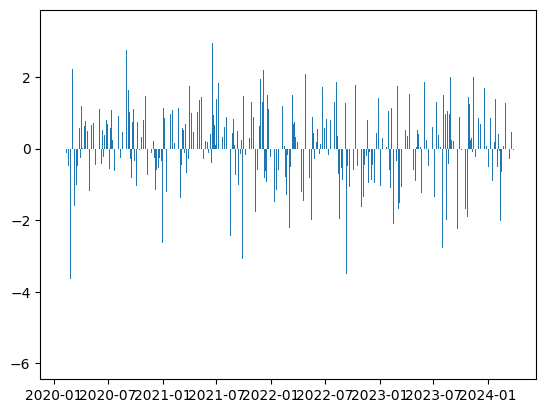

In [112]:
plt.bar(dates, spikes)

## Option Back Test

In [19]:
import os
import sys
import numpy as np

In [2]:
data_folder_path = os.path.join(os.getcwd(), 'option_data')
sys.path.append(data_folder_path)

In [3]:
from option_data import OptionFactory
import utils

In [4]:
start_date: str = "2024-02-05"
end_date: str = '2024-03-22'
ticker: str = "META"
expiration: str = '2024-03-22'
K: int = 460

In [5]:
def historical_option_price(ticker: str, K: int, start_date: str, end_date: str, expiration: str, option_style: str = "european", option_type: str = "call") -> list[float]:

    close_dates: list[str] = utils.option_date_range(start_date, end_date)

    meta_option_price_list: list[int] = []

    for close_date in close_dates:
        option_price: float = OptionFactory().create_option(ticker, K, expiration, close_date, option_style, option_type).get_price()
        meta_option_price_list.append(option_price)

    return meta_option_price_list, close_dates

In [25]:
import matplotlib.pyplot as plt

def plot_option_price(x: list[str], y: list[float]):

    plt.figure()
    plt.plot(x, y)
    plt.xticks(rotation=60)
    plt.xlabel("Close Date")
    plt.ylabel("Option Price")
    plt.show()

In [32]:
ticker = "SPY"
start_date = "2024-02-15"
end_date = "2024-04-15"
expiration = "2024-04-19"
K1 = 500
K2 = 510

spy_call_k1, dates1 = historical_option_price(ticker, K1, start_date, end_date, expiration)
spy_call_k2, dates2 = historical_option_price(ticker, K2, start_date, end_date, expiration)

In [36]:
call_spread = np.array(spy_call_k1) - np.array(spy_call_k2)

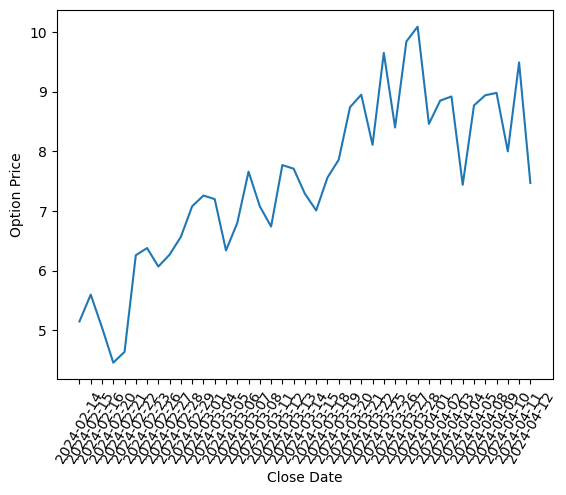

In [37]:
plot_option_price(dates1, call_spread)

## Option Position

In [127]:
import numpy as np
import matplotlib.pyplot as plt

from option_data import historical_option_prices
from option_data import OptionFactory
from calc_engine.option_pricing import analytical_solutions as ans

In [130]:
spy_node = OptionFactory().create_option("SPY", 510, "2024-04-19", "2024-02-15")
spy_node.get_implied_volatility()
spy_node.get_dte()
bsm_price = ans.bsm_call(100, 100, .5, .4, .02, 0)
bsm_price

dte 64


11.016004061566335

In [ ]:


class Positions:

    def __init__(self, ticker: str, strike: int, expiration: str):
        self._ticker: str = ticker
        self._strike: int = strike
        self._expiration: str = expiration

    def payoff(self):
        return None

    def back_test(self):
        return None

## Option Pricing

In [50]:
def monte_carlo_simulation_bs(S0, M, I, T, sigma, r) -> list:

    if T > 1:
        T /= 252
    dt = T / M
    S = np.zeros((M + 1, I))
    S[0] = S0
    rn = np.random.standard_normal(S.shape)
    for t in range(1, M + 1):   # 1
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t])  # 2
    #return S
    return rn

def mc_call_price(S0, K, M, I, T, sigma, r) -> float:
    
    S: list = monte_carlo_simulation(S0, M, I, T, sigma, r)
    return np.exp(-r * T) * np.maximum(S[-1] - K, 0).mean()

rn = monte_carlo_simulation_bs(100, 5, 10, 1/2, .2, .02)

In [ ]:
import math
import numpy as np
from scipy.integrate import quad


def M76_call_value(mar_env):
    ''' Valuation of European call option in M76 model via Lewis (2001)
    Fourier-based approach.

    Parameters
    ==========
    initial_value : float
        initial stock/index level
    strike : float
        strike price
    maturity : datetime object
        time-to-maturity (for t=0)
    short_rate : float
        constant risk-free short rate
    volatility : float
        volatility factor diffusion term
    lamb : float
        jump intensity
    mu : float
        expected jump size
    delta : float
        standard deviation of jump

    Returns
    =======
    call_value: float
        present value of European call option
    '''

    try:
        S0 = mar_env.get_constant('initial_value')
        K = mar_env.get_constant('strike')
        T = (mar_env.get_constant('maturity') -
             mar_env.pricing_date).days / 365.
        r = mar_env.get_curve('discount_curve').short_rate
        lamb = mar_env.get_constant('lambda')
        mu = mar_env.get_constant('mu')
        delta = mar_env.get_constant('delta')
        volatility = mar_env.get_constant('volatility')
    except:
        print('Error parsing market environment.')

    int_value = quad(lambda u:
                     M76_int_func_sa(
                         u, S0, K, T, r, volatility, lamb, mu, delta),
                     0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) /
                     np.pi * int_value)
    return call_value


def M76_put_value(mar_env):
    ''' Valuation of European put option in M76 model via Lewis (2001)
    Fourier-based approach. '''

    try:
        S0 = mar_env.get_constant('initial_value')
        K = mar_env.get_constant('strike')
        T = (mar_env.get_constant('maturity') -
             mar_env.pricing_date).days / 365.
        r = mar_env.get_curve('discount_curve').short_rate
    except:
        print('Error parsing market environment.')

    call_value = M76_call_value(mar_env)
    put_value = call_value + K * math.exp(-r * T) - S0
    return put_value


def M76_int_func_sa(u, S0, K, T, r, volatility, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via Lewis (2001)
    Fourier-based approach: integration function.

    Parameter definitions see function M76_call_value.'''
    char_func_value = M76_char_func_sa(u - 0.5 * 1j, T, r, volatility,
                                       lamb, mu, delta)
    int_func_value = 1 / (u ** 2 + 0.25) \
        * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value


def M76_char_func_sa(u, T, r, volatility, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via Lewis (2001)
    Fourier-based approach: characteristic function 'jump component'.

    Parameter definitions see function M76_call_value.'''
    omega = r - 0.5 * volatility ** 2 \
        - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega -
                              0.5 * u ** 2 * volatility ** 2 +
                              lamb * (np.exp(1j * u * mu -
                              u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

In [117]:
from scipy.integrate import quad
val = quad(a = 2, b = 4, func = )
val

TypeError: quad() missing 1 required positional argument: 'func'

In [126]:
def m7_stoch_jump_call_func(S0, K, T, r, volatility, lamb, mu, delta):

    def integer_function(u, S0, K, T, r, volatility, lamb, mu, delta):
        omega = r - 0.5 * volatility ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
        char_func_value = np.exp((1j * u * omega - 0.5 * u ** 2 * volatility ** 2 + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
        int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
        return int_func_value

    int_value = quad(lambda u:
                     integer_function(
                         u, S0, K, T, r, volatility, lamb, mu, delta),
                     0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) /
                     np.pi * int_value)
    return call_value

m7_stoch_jump_call_func(100, 103, .5, .02, .2, .6, .8, .1)

18.606650657913292